<a href="https://colab.research.google.com/github/MiniEinsteinD/EvilTwinAttackDetection/blob/main/EvilTwinAttackDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training SVM

In [ ]:
!git clone https://github.com/silvamleandro/EvilTwin_detection.git

fatal: destination path 'EvilTwin_detection' already exists and is not an empty directory.


In [ ]:
%cd /content/EvilTwin_detection/src

**Training and Test**

In [ ]:
!pip install pycaret

In [ ]:
!pip install optuna

In [ ]:
# Imports
from imblearn.over_sampling import KMeansSMOTE
from pathlib import Path
from pycaret.classification import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, roc_curve
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from time import time
from utils import split_X_y # utils.py

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import pickle
import warnings
import xgboost as xgb
import pycaret
import time


# Ignore Pandas warnings
warnings.filterwarnings("ignore")

# Random state default
RANDOM_STATE = 42

In [ ]:
def plot_roc_curve(model, fpr, tpr, roc_auc, k,
                   save_figure=False, reports_path=None, file_name=None):
    # Config the plot
    plt.figure(figsize=(10,10))
    plt.grid()
    plt.plot([0, 1], [0, 1], ls='--')
    plt.ylim([-0.01, 1.01])
    plt.xlim([-0.01, 1.01])
    plt.xlabel('False Positive Rate', size=16)
    plt.ylabel('True Positive Rate', size=16)

    linspace = np.linspace(0, 1, 100)

    # Calculate the mean ROC
    int_tpr = [np.interp(linspace, fpr[i], tpr[i]) for i in range(k)]
    mean_tpr = np.mean(int_tpr, axis=0)

    # Plot all ROC curves for each fold and the average ROC curve
    for i in range(k):
        plt.plot(fpr[i], tpr[i], label=f'fold {i + 1}, Area: {roc_auc[i]:.5f}')

    plt.plot(linspace, mean_tpr, label=f'Average Curve, Area: {auc(linspace, mean_tpr):.5f} (+/- {np.std(roc_auc)*2:.5f})')

    # Plot the graph
    plt.legend(prop={'size': 16})
    # Save the ROC curve
    plt.savefig(f'{reports_path}images/{file_name}-roc_curve.png')
    plt.show() # Show the plot



def plot_confusion_matrix(y_true, y_pred, class_names, normalized,
                          save_figure=False, reports_path=None, file_name=None):
    # Get confusion matrix
    cm = confusion_matrix(y_true, y_pred, normalize=normalized)
    # Confusion matrix display
    cm_p = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(7,7)) # Plot size
    plt.rcParams.update({'font.size': 14}) # Font size
    cm_p.plot(ax=ax) # Confusion matrix plot show

    if save_figure == True: # Save figure
        plt.savefig(f'{reports_path}images/{file_name}-cm.png')

    # Return confusion matrix
    return cm



def classification_with_report(model, X, y, k, class_names, save_report=False,
                               reports_path=None, file_name=None, verbose=True):
    # Lists
    fpr, tpr, roc_auc = [], [], []
    original_label, predicted_label, predicted_proba = [], [], []

    # Stratified K-Fold cross-validation
    skf = StratifiedKFold(k)

    # Time counting
    start = time()

    # Train and test the model for each 'k' fold in all the data
    for train_index, test_index in skf.split(X,y):
        model.fit(X.iloc[train_index], y[train_index])
        y_pred_probability = model.predict_proba(X.iloc[test_index])

        # Predict to generate classification report
        y_pred = model.predict(X.iloc[test_index])
        predicted_label.extend(y_pred)
        original_label.extend(y[test_index])

        # Compute micro-average ROC curve and ROC area
        temp_fpr, temp_tpr, _ = roc_curve(y[test_index], y_pred_probability[:,1])
        fpr.append(temp_fpr)
        tpr.append(temp_tpr)
        roc_auc.append(auc(temp_fpr, temp_tpr))

    # Total time spent on training
    total_time = time() - start

    if verbose == True: # Show results
        # Results
        print('\t\t\tClassification Report\n\n')
        print(classification_report(original_label, predicted_label, target_names=class_names, digits=5))
        print('Accuracy: ' + str(round(accuracy_score(original_label, predicted_label), 5)))
        print('F1-Score: ' + str(round(f1_score(original_label, predicted_label), 5)))
        print('Precision: ' + str(round(precision_score(original_label, predicted_label), 5)))
        print('Recall: ' + str(round(recall_score(original_label, predicted_label), 5)))
        print('AUC: ' + str(round(np.mean(roc_auc), 5)))
        print('Total Time: ' + str(round(total_time, 5)) + ' seconds')
        print('Confusion Matrix:\n')
        # Plot the ROC curve
        plot_roc_curve(model, fpr, tpr, roc_auc, k)
        # Plot the confusion matrix
        _ = plot_confusion_matrix(original_label, predicted_label, class_names, None)

    if save_report == True: # Save report
        # file_name (without extension)
        with open(reports_path + file_name + '.txt', 'a+') as f:
            f.write(type(model).__name__ + '\n ')
            f.write(str(model))
            f.write('\n\n\n')
            f.write('\t\t\tClassification Report\n\n')
            f.write(classification_report(original_label, predicted_label, target_names=class_names, digits=5))
            f.write('\n\nAccuracy: ' + str(round(accuracy_score(original_label, predicted_label), 5)))
            f.write('\n\nF1-Score: ' + str(round(f1_score(original_label, predicted_label), 5)))
            f.write('\n\nPrecision: ' + str(round(precision_score(original_label, predicted_label), 5)))
            f.write('\n\nRecall: ' + str(round(recall_score(original_label, predicted_label), 5)))
            f.write('\nAUC: ' + str(round(np.mean(roc_auc), 5)))
            f.write('\nTotal Time: ' + str(round(total_time, 5)) + ' seconds\n\n')
            # Save the ROC curve
            plot_roc_curve(model, fpr, tpr, roc_auc, k,
                           save_figure=True, reports_path=reports_path, file_name=file_name)
            # Save the confusion matrix
            _ = plot_confusion_matrix(original_label, predicted_label, class_names, None,
                                      save_figure=True, reports_path=reports_path, file_name=file_name)

    return model # Return trained model



def report_model(model, X, y, class_names, normalized='true'):
    # Predict to generate report
    y_pred = model.predict(X)

    # Results
    print('\t\t\tClassification Report\n\n')
    print(classification_report(y, y_pred, target_names=class_names, digits=5))

    # Confusion matrix
    print('\nConfusion Matrix:\n')
    cm = plot_confusion_matrix(y, y_pred, class_names, normalized)
    # True Negative (TN)
    tn = cm[0][0]
    # False Negative (FN)
    fn = cm[1][0]
    # True Positive (TP)
    tp = cm[1][1]
    # False Positive (FP)
    fp = cm[0][1]
    # True Positive Rate (TRP)
    tpr = tp / (tp + fn)
    # False Positive Rate (FPR)
    fpr = fp / (fp + tn)
    print(f'True Positive Rate (TPR): {round(tpr, 5)}')
    print(f'False Positive Rate (FPR): {round(fpr, 5)}')


In [ ]:
# General path
path = f'/content/EvilTwin_detection/'
# Pre-processed data path
preprocessed_data_path = f'{path}data/pre_processed/'
# Path to save the models
models_path = f'{path}/models/'
# Path to save results
reports_path = f'{path}/reports/'

# Load pre-processed training dataset
train_df = pd.read_csv(preprocessed_data_path + 'train_data.csv')
# Load pre-processed test dataset
test_df = pd.read_csv(preprocessed_data_path + 'test_data.csv')

In [ ]:
# Split train data into X and y
X_train, y_train = split_X_y(train_df)
# Split test data into X and y
X_test, y_test = split_X_y(test_df)

# Balance train data with SMOTE
X_res, y_res = KMeansSMOTE(random_state=RANDOM_STATE).fit_resample(X_train, y_train)


			Classification Report


              precision    recall  f1-score   support

      Normal    1.00000   0.99015   0.99505     24272
   Evil Twin    0.69280   1.00000   0.81853       539

    accuracy                        0.99037     24811
   macro avg    0.84640   0.99508   0.90679     24811
weighted avg    0.99333   0.99037   0.99122     24811


Confusion Matrix:

True Positive Rate (TPR): 1.0
False Positive Rate (FPR): 0.00985


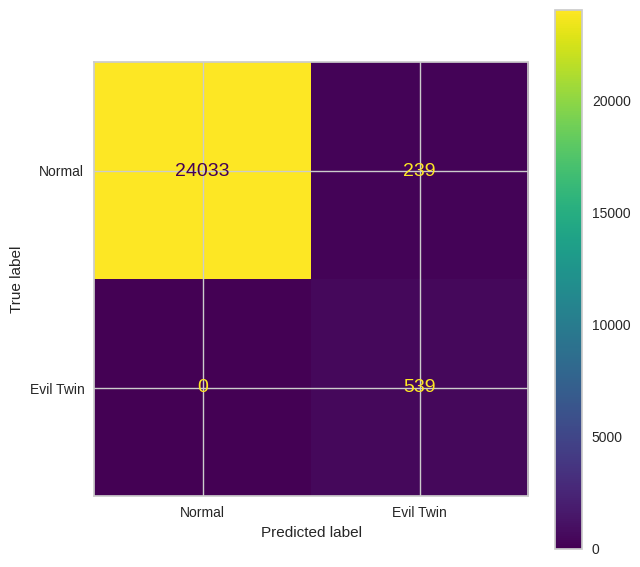

In [ ]:
# Define the neural network model
nn_model = MLPClassifier(random_state=RANDOM_STATE)

# Train the model on the balanced training data
nn_model.fit(X_res, y_res)

# Predict labels for the test data
y_pred_nn = nn_model.predict(X_test)

report_model(nn_model, X_test, y_test, ['Normal', 'Evil Twin'], None)


			Classification Report


              precision    recall  f1-score   support

      Normal    1.00000   0.98908   0.99451     24272
   Evil Twin    0.67040   1.00000   0.80268       539

    accuracy                        0.98932     24811
   macro avg    0.83520   0.99454   0.89860     24811
weighted avg    0.99284   0.98932   0.99034     24811


Confusion Matrix:

True Positive Rate (TPR): 1.0
False Positive Rate (FPR): 0.01092


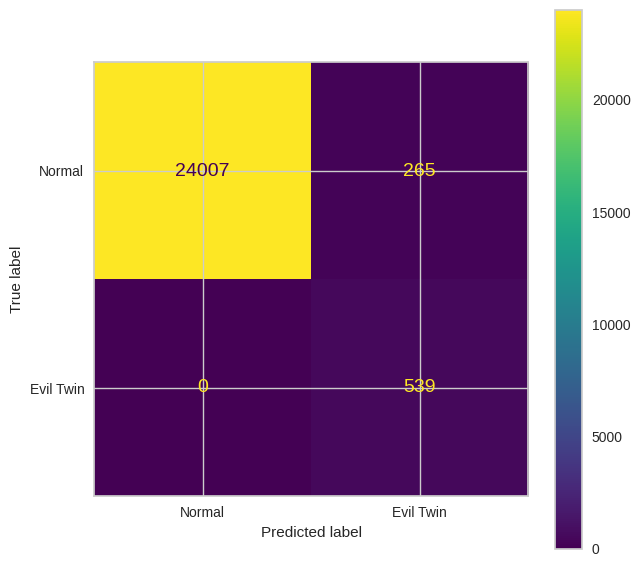

In [ ]:
from sklearn.svm import SVC
# Define the SVM model with RBF kernel
svm_rbf_model = SVC(kernel='rbf', random_state=RANDOM_STATE)

# Train the model on the balanced training data
svm_rbf_model.fit(X_res, y_res)

# Predict labels for the test data
y_pred_svm_rbf = svm_rbf_model.predict(X_test)

report_model(svm_rbf_model, X_test, y_test, ['Normal', 'Evil Twin'], None)

In [ ]:
import time
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def train_model_and_get_metrics(model, X_train, y_train, X_test, y_test):
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    train_time = end_time - start_time

    y_pred = model.predict(X_test)

    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred)
    }

    if isinstance(model, SVC):
        decision_scores = model.decision_function(X_test)
        metrics['AUC'] = roc_auc_score(y_test, decision_scores)
    elif isinstance(model, MLPClassifier):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        metrics['AUC'] = roc_auc_score(y_test, y_pred_proba)

    return metrics, train_time

# Define models
models = {
    'SVM with RBF Kernel': SVC(kernel='rbf', random_state=RANDOM_STATE),
    'Neural Network': MLPClassifier(random_state=RANDOM_STATE)
}

# Train models and get metrics
metrics = {}
times = {}
for model_name, model in models.items():
    metrics[model_name], times[model_name] = train_model_and_get_metrics(model, X_res, y_res, X_test, y_test)

# Display metrics
for model_name, metric in metrics.items():
    print(f"{model_name}:")
    for metric_name, value in metric.items():
        print(f"{metric_name}: {value}")
    print(f"TT (Sec): {round(times[model_name], 4)}\n")


SVM with RBF Kernel:
Accuracy: 0.9893192535568901
F1-Score: 0.802680565897245
Precision: 0.6703980099502488
Recall: 1.0
AUC: 0.9989641591340198
TT (Sec): 0.1718

Neural Network:
Accuracy: 0.9903671758494216
F1-Score: 0.8185269552012149
Precision: 0.6928020565552699
Recall: 1.0
AUC: 0.9978433581438807
TT (Sec): 24.767

